In [12]:
import pandas as pd
#df = pd.read_csv('C:\main_task.csv')
#City = pd.read_excel("C:\city.xlsx")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [13]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [14]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [15]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('C:\main_task.csv')
df_test = pd.read_csv('C:\kaggle_task.csv')
sample_submission = pd.read_csv('C:\sample_submission.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


### Dummy "City"

In [16]:
df1 = data.copy()
a = pd.get_dummies(df1['City'])

In [17]:
frames = [data, a]
data = pd.concat(frames, axis = 1)

### Столица или нет

In [18]:
Capital = ['Paris', 'Stockholm', 'London', 'Berlin', 'Bratislava', 'Vienna','Rome','Madrid', 'Dublin', 'Brussels','Warsaw', 'Budapest',
'Copenhagen','Amsterdam', 'Lisbon','Prague', 'Oslo', 'Helsinki', 'Edinburgh', 'Ljubljana','Athens','Luxembourg']
def Capital_or_not(City):
    if City in Capital:
        return 1
    else:
        return 0
data['Capital_or_not'] = data.City.apply(Capital_or_not)
#0.37

### 'Price Range'

In [19]:
def price(x):
    if x == '$':
        return 1
    elif x == '$$ - $$$':
        return 2
    elif x == '$$$$':
        return 3
#    else:
#        return price4/len(df)
data['Price Range'] = data['Price Range'].apply(price)
data['Price Range'] = data['Price Range'].fillna(2)

### 'Cuisine Style' - количество

In [20]:
def evalisation(x):
    try:
        return eval(x)
    except TypeError:
        return None
types_kitchens = data['Cuisine Style'].dropna()

def lenalisation(x):
    if x == None:
        return 0
    else:
        return len(x)
    
types_kitchens = pd.DataFrame(data = types_kitchens)
types_kitchens['number_of_kitchens'] = types_kitchens['Cuisine Style'].apply(evalisation)
types_kitchens['number_of_kitchens'] = types_kitchens['number_of_kitchens'].apply(lenalisation)
#types_kitchens.head()

In [21]:
data['number_of_kitchens'] = types_kitchens['number_of_kitchens']

In [22]:
data['number_of_kitchens'].fillna(1,inplace = True)

In [23]:
def kak(dfd):
    if dfd == '[[], []]':
        return 0
    else:
        return 1
data['Number of Reviews'].fillna(data['Reviews'].apply(kak),inplace = True)

### 'Reviews'

In [24]:
data['Reviews'] = data['Reviews'].fillna("['nodata']")    
data['Date'] = data['Reviews'].str.findall('\d+\/\d+\/\d+')
def time(x):
    if x == []:
         return None
    return pd.to_datetime(x).max() - pd.to_datetime(x).min()
data['Date'] = data['Date'].apply(time)
data['Date'] = data['Date'].apply(lambda x: x.days)
data['Date'] = data['Date'].fillna(data['Date'].median())

In [25]:
population = {'Paris': 2190327, 'Stockholm': 961609, 'London': 8908081, 'Berlin': 3644826, 'Munich': 1456039, 
              'Oporto': 237591,'Milan': 1378689,'Bratislava': 432864, 'Vienna': 1821582, 'Rome': 4355725, 
              'Barcelona': 1620343, 'Madrid': 3223334,'Dublin': 1173179,'Brussels': 179277, 'Zurich': 428737, 
              'Warsaw': 1758143, 'Budapest': 1752286, 'Copenhagen': 615993,'Amsterdam': 857713,'Lyon': 506615, 
              'Hamburg': 1841179,'Lisbon': 505526, 'Prague': 1301132, 'Oslo': 673469,'Helsinki': 643272, 
              'Edinburgh': 488100,'Geneva': 200548, 'Ljubljana': 284355,'Athens': 664046, 'Luxembourg': 115227,
              'Krakow': 769498}
data['Population'] = data['City'].map(population)

###

In [26]:
data['ID_TA'] = data['ID_TA'].apply(lambda x: float(x[1:]))

In [27]:
data['URL_TA'] = data['URL_TA'].apply(lambda x: float(x[20:25]))

In [28]:
df3 = data.copy()
df3['Cuisine Style'].dropna(inplace = True)
df3['Cuisine Style'] = df3['Cuisine Style'].apply(lambda x: x.replace("[","").replace("]","").replace(" ", "").replace("'","").split(','))

In [29]:
a = pd.get_dummies(df3['Cuisine Style'].apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)

In [30]:
frames = [data, a]
data = pd.concat(frames, axis = 1)

In [31]:
Number_of_restaurants = {'Paris': 16661, 'Helsinki': 1471, 'Edinburgh': 1851, 'London': 19360, 'Bratislava': 1199, 
                         'Lisbon': 4682,'Budapest': 2926, 'Stockholm': 2875, 'Rome': 10577, 'Milan': 7025, 'Munich': 3021,
                         'Hamburg': 3152, 'Ljubljana': 580, 'Geneva': 1676, 'Zurich': 1791, 'Luxembourg': 716, 
                         'Copenhagen': 2329, 'Krakow': 1587, 'Oporto': 1898, 'Warsaw': 3002, 'Athens': 2438, 
                         'Lyon': 2703, 'Berlin': 7162, 'Amsterdam': 3851, 'Oslo': 1308, 'Madrid': 10884, 'Brussels': 3519,
                         'Barcelona': 9311, 'Dublin': 2311, 'Vienna': 3956, 'Prague': 5233}


data['Number_of_restaurants'] = data['City'].apply(lambda x: Number_of_restaurants[x])

In [32]:
data['Rat'] = data['Ranking'] / data['Number_of_restaurants']


In [33]:
data.drop(['City','Cuisine Style', 'Reviews', 'URL_TA','Restaurant_id'], axis=1, inplace = True)

In [34]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [35]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [36]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 167), (40000, 167), (40000, 166), (32000, 166), (8000, 166))

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [39]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [40]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [41]:
for i in range (len(y_pred)):
    y_pred[i] = round(y_pred[i]*2)/2

In [42]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1703125


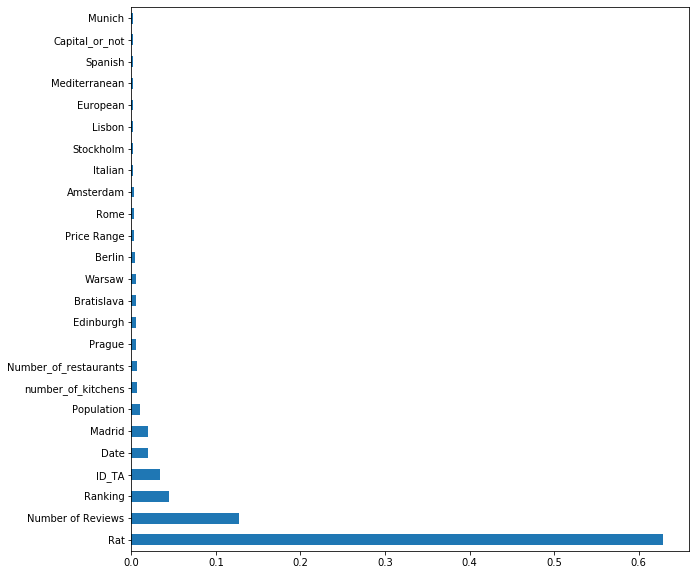

In [43]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [44]:
test_data = test_data.drop(['Rating'], axis=1)

In [45]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [46]:
for i in range (len(predict_submission)):
    predict_submission[i] = round(predict_submission[i]*2)/2
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [47]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,3.0
8,id_8,4.5
9,id_9,4.5
